In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy as sp
from scipy import stats

import sklearn

#misc libraries
import random
import time

from subprocess import check_output
print(check_output(["ls", "./data/all/"]).decode("utf8"))

gender_submission.csv
test.csv
train.csv



In [2]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [ ]:
from sklearn.model_selection import cross

In [3]:
data_raw = pd.read_csv('data/all/train.csv')

In [4]:
data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data_val = pd.read_csv('data/all/test.csv')

In [6]:
data1 = data_raw.copy(deep = True)

In [7]:
data_cleaner = [data1, data_val]

## 3.21 The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting
In this stage, we will clean our data by 1) correcting aberrant values and outliers, 2) completing missing information, 3) creating new features for analysis, and 4) converting fields to the correct format for calculations and presentation.

1. **Correcting:** Reviewing the data, there does not appear to be any aberrant or non-acceptable data inputs. In addition, we see we may have potential outliers in age and fare. However, since they are reasonable values, we will wait until after we complete our exploratory analysis to determine if we should include or exclude from the dataset. It should be noted, that if they were unreasonable values, for example age = 800 instead of 80, then it's probably a safe decision to fix now. However, we want to use caution when we modify data from its original value, because it may be necessary to create an accurate model.
2. **Completing:** There are null values or missing data in the age, cabin, and embarked field. Missing values can be bad, because some algorithms don't know how-to handle null values and will fail. While others, like decision trees, can handle null values. Thus, it's important to fix before we start modeling, because we will compare and contrast several models. There are two common methods, either delete the record or populate the missing value using a reasonable input. It is not recommended to delete the record, especially a large percentage of records, unless it truly represents an incomplete record. Instead, it's best to impute missing values. A basic methodology for qualitative data is impute using mode. A basic methodology for quantitative data is impute using mean, median, or mean + randomized standard deviation. An intermediate methodology is to use the basic methodology based on specific criteria; like the average age by class or embark port by fare and SES. There are more complex methodologies, however before deploying, it should be compared to the base model to determine if complexity truly adds value. For this dataset, age will be imputed with the median, the cabin attribute will be dropped, and embark will be imputed with mode. Subsequent model iterations may modify this decision to determine if it improves the model’s accuracy.
3. **Creating:**  Feature engineering is when we use existing features to create new features to determine if they provide new signals to predict our outcome. For this dataset, we will create a title feature to determine if it played a role in survival.
4. **Converting:** Last, but certainly not least, we'll deal with formatting. There are no date or currency formats, but datatype formats. Our categorical data imported as objects, which makes it difficult for mathematical calculations. For this dataset, we will convert object datatypes to categorical dummy variables.

In [8]:
data1.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
data1.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [10]:
###COMPLETING: complete or delete missing values in train and test/validation dataset
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace=True)

In [11]:
data1.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [12]:
###CREATE: Feature Engineering for train and test/validation dataset
for dataset in data_cleaner:    
    #Discrete variables
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    #quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]


    #Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    #Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


(16.0, 32.0]
(32.0, 48.0]
(48.0, 64.0]
(-0.08, 16.0]
(64.0, 80.0]


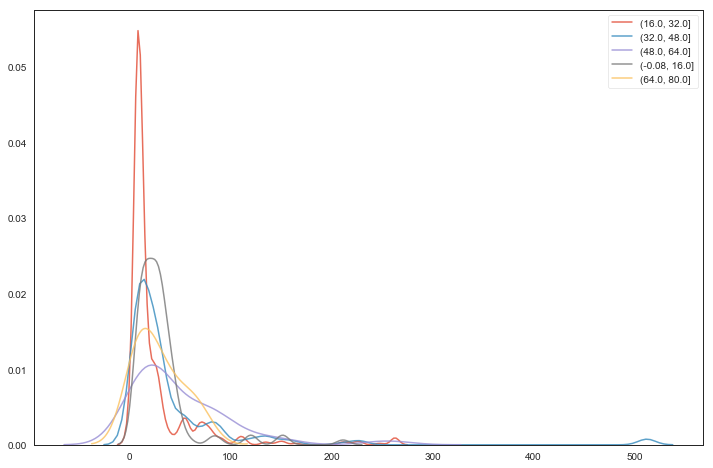

In [13]:
for demo in data1['AgeBin'].unique():
    print(demo)
    # Select the demographic
    subset = data1[data1['AgeBin'] == demo]
    # Density plot of Fare by demo
    sns.kdeplot(subset['Fare'].dropna(), label = demo, shade = False, alpha = 0.8);

In [14]:
data1.groupby('AgeBin')['Fare'].agg([np.min,np.max,stats.mode,np.median,np.mean,np.std])

,amin,amax,mode,median,mean,std
AgeBin,,,,,,
"(-0.08, 16.0]",7.225,211.3375,"([31.275], [5])",26.00000,31.588877,31.882021
"(16.0, 32.0]",0.000,263.0000,"([7.8958], [32])",10.46250,26.177657,40.731818
"(32.0, 48.0]",0.000,512.3292,"([13.0], [15])",24.86875,43.017473,72.793359
"(48.0, 64.0]",0.000,263.0000,"([26.55], [6])",29.70000,50.327235,51.239594
"(64.0, 80.0]",7.750,71.0000,"([7.75], [2])",26.55000,28.905691,23.128014


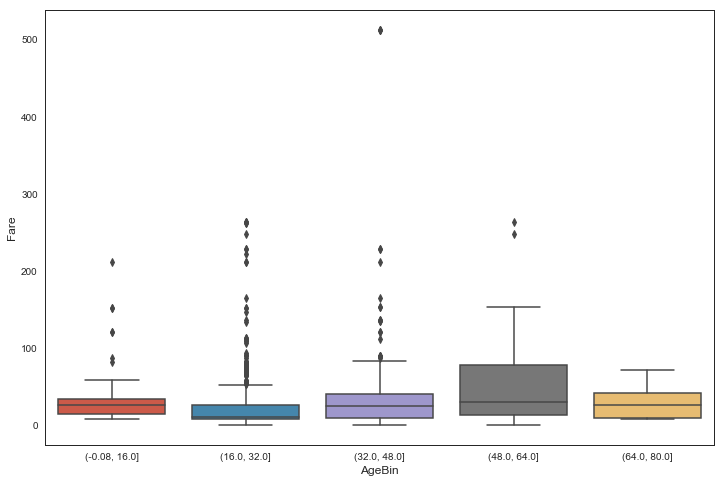

In [15]:
sns.boxplot(x="AgeBin", y="Fare", data=data1)

In [16]:
#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (data1['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*10)


#preview data again
data1.info()
data_val.info()
data1.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null 

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
503,0,3,"Laitinen, Miss. Kristina Sofia",female,37.00,0,0,9.5875,S,1,1,Miss,"(7.91, 14.454]","(32.0, 48.0]"
250,0,3,"Reed, Mr. James George",male,28.00,0,0,7.2500,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
422,0,3,"Zimmerman, Mr. Leo",male,29.00,0,0,7.8750,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
218,1,1,"Bazzani, Miss. Albina",female,32.00,0,0,76.2917,C,1,1,Miss,"(31.0, 512.329]","(16.0, 32.0]"
308,0,2,"Abelson, Mr. Samuel",male,30.00,1,0,24.0000,C,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"
703,0,3,"Gallagher, Mr. Martin",male,25.00,0,0,7.7417,Q,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
457,1,1,"Kenyon, Mrs. Frederick R (Marion)",female,28.00,1,0,51.8625,S,2,0,Mrs,"(31.0, 512.329]","(16.0, 32.0]"
755,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,14.5000,S,3,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
594,0,2,"Chapman, Mr. John Henry",male,37.00,1,0,26.0000,S,2,0,Mr,"(14.454, 31.0]","(32.0, 48.0]"
684,0,2,"Brown, Mr. Thomas William Solomon",male,60.00,1,1,39.0000,S,3,0,Mr,"(31.0, 512.329]","(48.0, 64.0]"


## 3.23 Convert Formats

We will convert categorical data to dummy variables for mathematical analysis. There are multiple ways to encode categorical variables; we will use the sklearn and pandas functions.

In this step, we will also define our x (independent/features/explanatory/predictor/etc.) and y (dependent/target/outcome/response/etc.) variables for data modeling.

** Developer Documentation: **
* [Categorical Encoding](http://pbpython.com/categorical-encoding.html)
* [Sklearn LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
* [Sklearn OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
* [Pandas Categorical dtype](https://pandas.pydata.org/pandas-docs/stable/categorical.html)
* [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)

In [17]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

#code categorical data
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

In [18]:
data1.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,3,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]",1,2,3,2,1


In [19]:
#define y variable aka target/outcome
Target = ['Survived']

In [20]:
#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')

('Original X Y: ', ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'], '\n')


In [21]:
#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')

('Bin X Y: ', ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'], '\n')


In [22]:
#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

('Dummy X Y: ', ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'], '\n')


## 3.25 Split Training and Testing Data

As mentioned previously, the test file provided is really validation data for competition submission. So, we will use *sklearn* function to split the training data in two datasets; 75/25 split. This is important, so we don't [overfit our model](https://www.coursera.org/learn/python-machine-learning/lecture/fVStr/overfitting-and-underfitting). Meaning, the algorithm is so specific to a given subset, it cannot accurately generalize another subset, from the same dataset. It's important our algorithm has not seen the subset we will use to test, so it doesn't "cheat" by memorizing the answers. We will use [*sklearn's* train_test_split function](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). In later sections we will also use [*sklearn's* cross validation functions](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation), that splits our dataset into train and test for data modeling comparison.

In [23]:
#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


# Step 4: Perform Exploratory Analysis with Statistics
Now that our data is cleaned, we will explore our data with descriptive and graphical statistics to describe and summarize our variables. In this stage, you will find yourself classifying features and determining their correlation with the target variable and each other.

In [24]:
#Discrete Variable Correlation by Survival using
#group by aka pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        

#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(data1['Title'],data1[Target[0]]))

('Survival Correlation by:', 'Sex')
      Sex  Survived
0  female  0.742038
1    male  0.188908
('----------', '\n')
('Survival Correlation by:', 'Pclass')
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
('----------', '\n')
('Survival Correlation by:', 'Embarked')
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
('----------', '\n')
('Survival Correlation by:', 'Title')
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
('----------', '\n')
('Survival Correlation by:', 'SibSp')
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
('----------', '\n')
('Survival Correlation by:', 'Parch')
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
('----------', '\

/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


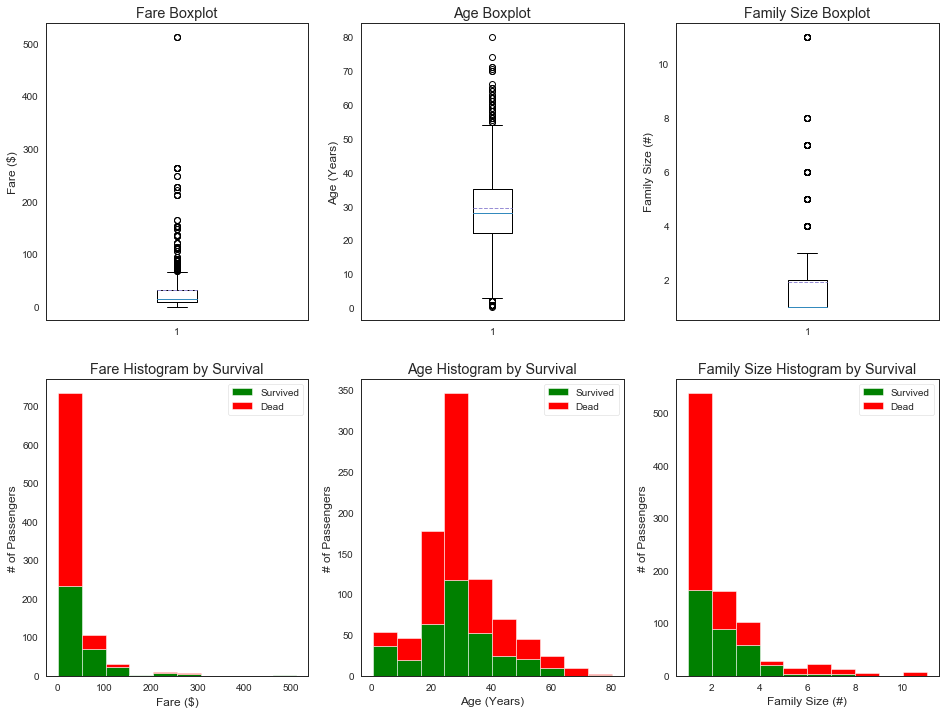

In [25]:
#IMPORTANT: Intentionally plotted different ways for learning purposes only. 

#optional plotting w/pandas: https://pandas.pydata.org/pandas-docs/stable/visualization.html

#we will use matplotlib.pyplot: https://matplotlib.org/api/pyplot_api.html

#to organize our graphics will use figure: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure
#subplot: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot
#and subplotS: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html?highlight=matplotlib%20pyplot%20subplots#matplotlib.pyplot.subplots

#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

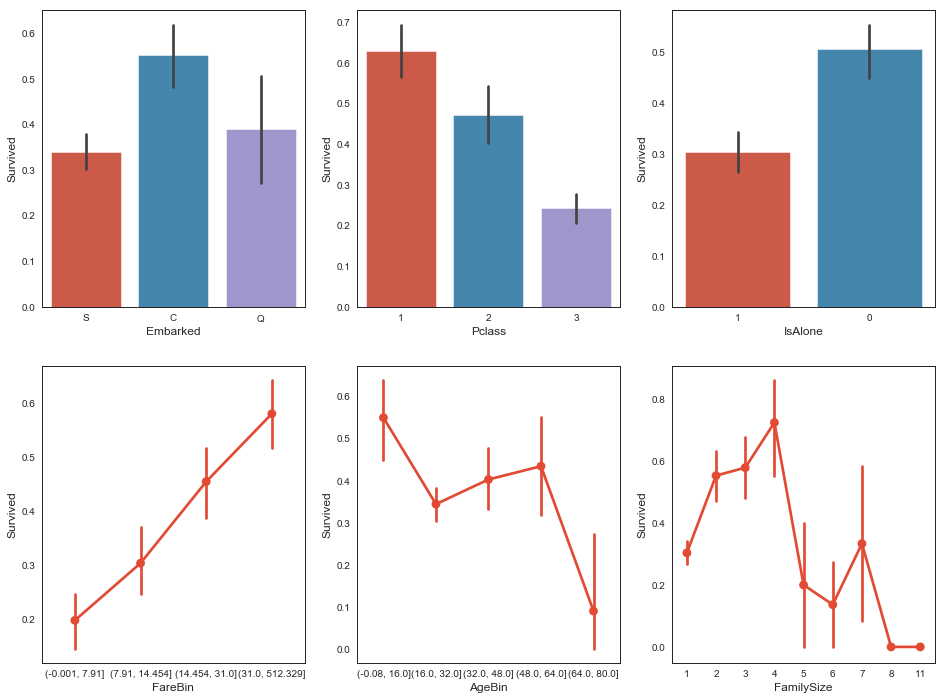

In [26]:
#we will use seaborn graphics for multi-variable comparison: https://seaborn.pydata.org/api.html

#graph individual features by survival
fig, saxis = plt.subplots(2, 3,figsize=(16,12))

sns.barplot(x = 'Embarked', y = 'Survived', data=data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', order=[1,0], data=data1, ax = saxis[0,2])

sns.pointplot(x = 'FareBin', y = 'Survived',  data=data1, ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived',  data=data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data=data1, ax = saxis[1,2])

Text(0.5,1,'Pclass vs Family Size Survival Comparison')

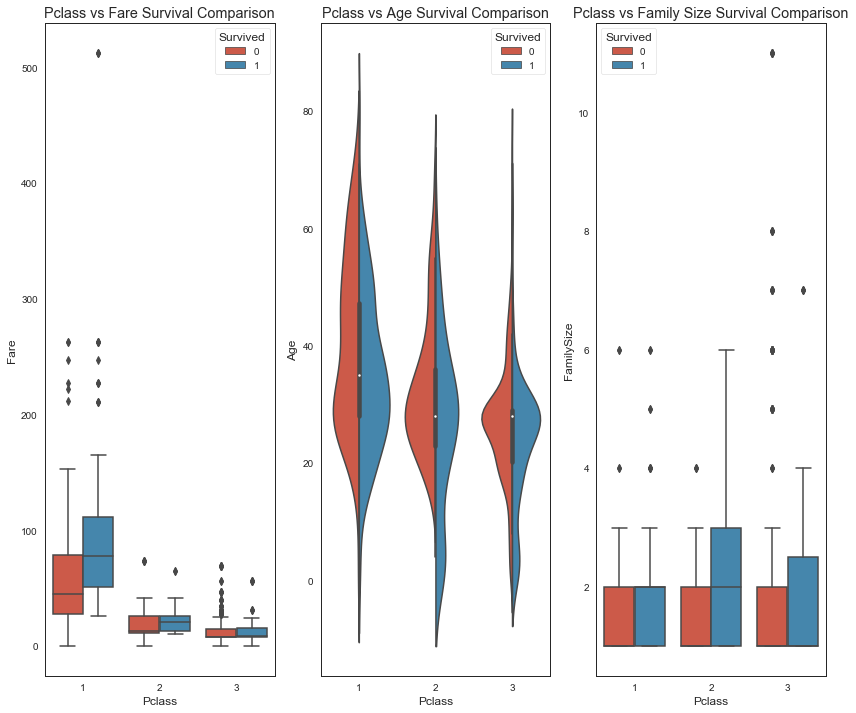

In [27]:
#graph distribution of qualitative data: Pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = data1, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

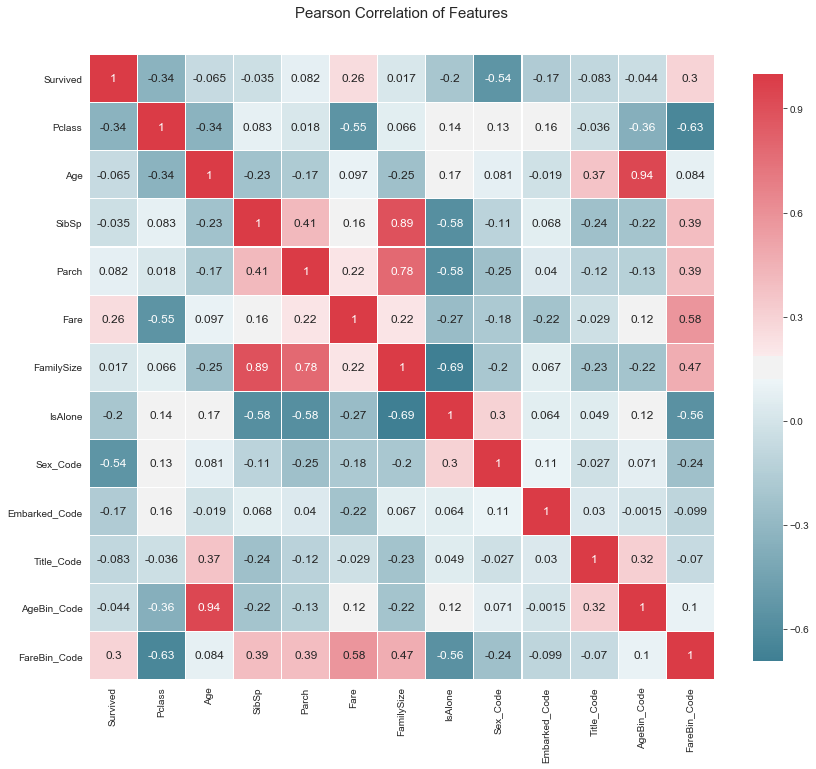

In [28]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

Text(0.5,1,'Sex vs IsAlone Survival Comparison')

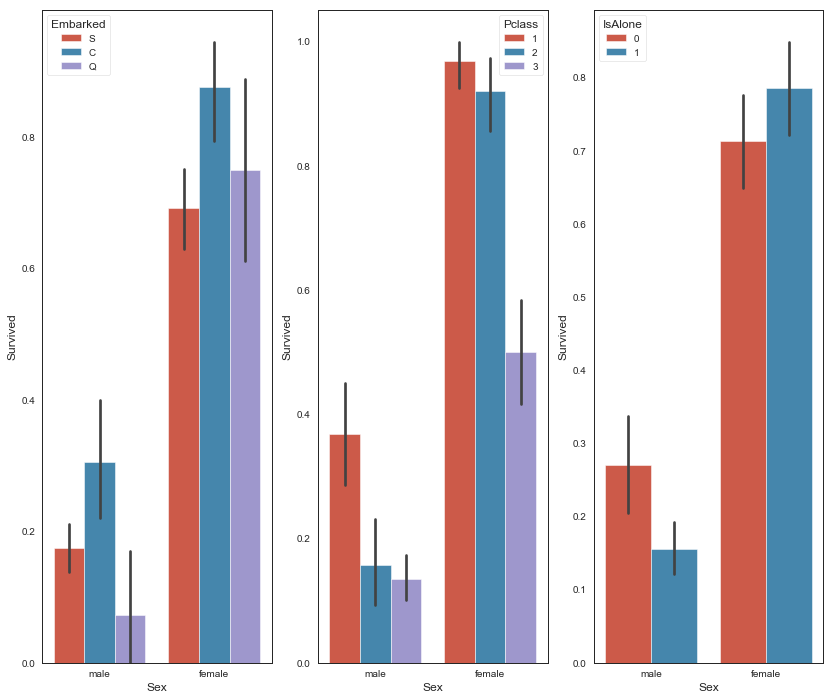

In [29]:
#graph distribution of qualitative data: Sex
#we know sex mattered in survival, now let's compare sex and a 2nd feature
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

# Step 5: Model Data
Data Science is a multi-disciplinary field between mathematics (i.e. statistics, linear algebra, etc.), computer science (i.e. programming languages, computer systems, etc.) and business management (i.e. communication, subject-matter knowledge, etc.). Most data scientist come from one of the three fields, so they tend to lean towards that discipline. However, data science is like a three-legged stool, with no one leg being more important than the other. So, this step will require advanced knowledge in mathematics. But don’t worry, we only need a high-level overview, which we’ll cover in this Kernel. Also, thanks to computer science, a lot of the heavy lifting is done for you. So, problems that once required graduate degrees in mathematics or statistics, now only take a few lines of code. Last, we’ll need some business acumen to think through the problem. After all, like training a sight-seeing dog, it’s learning from us and not the other way around.

Machine Learning (ML), as the name suggest, is teaching the machine how-to think and not what to think. While this topic and big data has been around for decades, it is becoming more popular than ever because the barrier to entry is lower, for businesses and professionals alike. This is both good and bad. It’s good because these algorithms are now accessible to more people that can solve more problems in the real-world. It’s bad because a lower barrier to entry means, more people will not know the tools they are using and can come to incorrect conclusions. That’s why I focus on teaching you, not just what to do, but why you’re doing it. Previously, I used the analogy of asking someone to hand you a Philip screwdriver, and they hand you a flathead screwdriver or worst a hammer. At best, it shows a complete lack of understanding. At worst, it makes completing the project impossible; or even worst, implements incorrect actionable intelligence. So now that I’ve hammered (no pun intended) my point, I’ll show you what to do and most importantly, WHY you do it.

First, you must understand, that the purpose of machine learning is to solve human problems. Machine learning can be categorized as: supervised learning, unsupervised learning, and reinforced learning. Supervised learning is where you train the model by presenting it a training dataset that includes the correct answer. Unsupervised learning is where you train the model using a training dataset that does not include the correct answer. And reinforced learning is a hybrid of the previous two, where the model is not given the correct answer immediately, but later after a sequence of events to reinforce learning. We are doing supervised machine learning, because we are training our algorithm by presenting it with a set of features and their corresponding target. We then hope to present it a new subset from the same dataset and have similar results in prediction accuracy.

There are many machine learning algorithms, however they can be reduced to four categories: classification, regression, clustering, or dimensionality reduction, depending on your target variable and data modeling goals. We'll save clustering and dimension reduction for another day, and focus on classification and regression. We can generalize that a continuous target variable requires a regression algorithm and a discrete target variable requires a classification algorithm. One side note, logistic regression, while it has regression in the name, is really a classification algorithm. Since our problem is predicting if a passenger survived or did not survive, this is a discrete target variable. We will use a classification algorithm from the *sklearn* library to begin our analysis. We will use cross validation and scoring metrics, discussed in later sections, to rank and compare our algorithms’ performance.

**Machine Learning Selection:**
* [Sklearn Estimator Overview](http://scikit-learn.org/stable/user_guide.html)
* [Sklearn Estimator Detail](http://scikit-learn.org/stable/modules/classes.html)
* [Choosing Estimator Mind Map](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* [Choosing Estimator Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf)


Now that we identified our solution as a supervised learning classification algorithm. We can narrow our list of choices.

**Machine Learning Classification Algorithms:**
* [Ensemble Methods](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Generalized Linear Models (GLM)](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Naive Bayes](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes)
* [Nearest Neighbors](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors)
* [Support Vector Machines (SVM)](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
* [Decision Trees](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree)
* [Discriminant Analysis](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.discriminant_analysis)


### Data Science 101: How to Choose a Machine Learning Algorithm (MLA)
**IMPORTANT:** When it comes to data modeling, the beginner’s question is always, "what is the best machine learning algorithm?" To this the beginner must learn, the [No Free Lunch Theorem (NFLT)](http://robertmarks.org/Classes/ENGR5358/Papers/NFL_4_Dummies.pdf) of Machine Learning. In short, NFLT states, there is no super algorithm, that works best in all situations, for all datasets. So the best approach is to try multiple MLAs, tune them, and compare them for your specific scenario. With that being said, some good research has been done to compare algorithms, such as [Caruana & Niculescu-Mizil 2006](https://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml06.pdf) watch [video lecture here](http://videolectures.net/solomon_caruana_wslmw/) of MLA comparisons, [Ogutu et al. 2011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3103196/) done by the NIH for genomic selection, [Fernandez-Delgado et al. 2014](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf) comparing 179 classifiers from 17 families, [Thoma 2016 sklearn comparison](https://martin-thoma.com/comparing-classifiers/), and there is also a school of thought that says, [more data beats a better algorithm](https://www.kdnuggets.com/2015/06/machine-learning-more-data-better-algorithms.html). 

So with all this information, where is a beginner to start? I recommend starting with [Trees, Bagging, Random Forests, and Boosting](http://jessica2.msri.org/attachments/10778/10778-boost.pdf). They are basically different implementations of a decision tree, which is the easiest concept to learn and understand. They are also easier to tune, discussed in the next section, than something like SVC. Below, I'll give an overview of how-to run and compare several MLAs, but the rest of this Kernel will focus on learning data modeling via decision trees and its derivatives.

In [32]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),  
    ]

In [33]:
#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict


AttributeError: 'module' object has no attribute 'cross_validate'